## Predictive analysis using ML

Objective - 
Create and implement a ML model to predict if a book will be returned late by a customer

To predict how likely a user is to return a book late or not, we will follow these steps - 

**Step 1: Data Preprocessing**
1. Data Cleaning:
    - Handle missing values: Fill or remove records with missing data as appropriate.
    - Correct any obvious data entry errors.

2. Encoding Categorical Variables:
    - Convert categorical variables into numerical format using techniques such as one-hot encoding for non-ordinal (nominal) categories (e.g., city, state, occupation) and label encoding for ordinal categories (e.g., education level).

3. Feature Engineering: (Future work)
    - Create new features if necessary, such as the distance between the customer and the library using the postal codes. 
    - Normalize or standardize numerical features to bring them onto a similar scale if needed.

**Step 2: Data Preparation**
1. Split Data:
    - Split the dataset into training and testing sets.

**Step 3: Model Selection**
- We can start with a simpler model like Logistic Regression to come up with a base model. However, it can struggle with categorical data with a large amount of features (like in our case). When categorical data is one-hot encoded, each category becomes a separate feature. If the original categorical variable has many levels, this results in a high-dimensional feature space. Logistic regression models can become less effective as the number of dimensions increases, leading to overfitting. 
- For this binary classification problem, several other machine learning models can be considered. Given the need to minimize false negatives with a large categorical feature set, models like Random Forest or XGBoost are suitable due to their ability to handle complex data and provide feature importance.

**Step 4: Model Training and Optimization**
- Random Forest Classifier:
    - Train a Random Forest model as it is robust and provides feature importance.
    - Use cross-validation to tune hyperparameters and validate the model.

**Step 5: Model Evaluation**
- Evaluation Metrics:
    - Evaluate the model using accuracy, precision, recall, F1-score, and AUC-ROC. Pay special attention to recall and precision, particularly the false negative rate.

**Step 6: Feature Importance**
- Feature Importance Analysis:
    - For Random Forest, use the feature_importances_ attribute to identify the key reason behind late returns

In [1]:
# Package imports
import numpy as np
import pandas as pd
from collections import Counter, defaultdict 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedStratifiedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTEN

pd.options.mode.chained_assignment = None

## Data Preprocessing

#### 1. Data Cleaning

In [2]:
library_records_df = pd.read_csv("data/library_records_status.csv")

In [3]:
library_records_df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'id_checkout', 'id_customer',
       'id_library', 'date_checkout', 'date_returned', 'name_customer',
       'street_address_customer', 'city_customer', 'state_customer',
       'zipcode_customer', 'birth_date_customer', 'customer_gender',
       'customer_education', 'customer_occupation', 'name_library',
       'street_address_library', 'city_library', 'region_library',
       'postal_code_library', 'num_days', 'return_status'],
      dtype='object')

In [4]:
library_records_df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'], inplace=True)

In [5]:
columns = library_records_df.columns

for col in columns:
    # print(col)
    print(library_records_df[col].isnull().value_counts(), end="\n"*2)

id_checkout
False    2000
Name: count, dtype: int64

id_customer
False    2000
Name: count, dtype: int64

id_library
False    2000
Name: count, dtype: int64

date_checkout
False    1935
True       65
Name: count, dtype: int64

date_returned
False    1942
True       58
Name: count, dtype: int64

name_customer
False    2000
Name: count, dtype: int64

street_address_customer
False    2000
Name: count, dtype: int64

city_customer
False    1906
True       94
Name: count, dtype: int64

state_customer
False    1898
True      102
Name: count, dtype: int64

zipcode_customer
False    1999
True        1
Name: count, dtype: int64

birth_date_customer
False    1893
True      107
Name: count, dtype: int64

customer_gender
False    1899
True      101
Name: count, dtype: int64

customer_education
False    1896
True      104
Name: count, dtype: int64

customer_occupation
False    1893
True      107
Name: count, dtype: int64

name_library
False    2000
Name: count, dtype: int64

street_address_library
F

In [6]:
library_records_df[library_records_df['city_customer'].isnull() == True]

,id_checkout,id_customer,id_library,date_checkout,date_returned,name_customer,street_address_customer,city_customer,state_customer,zipcode_customer,...,customer_gender,customer_education,customer_occupation,name_library,street_address_library,city_library,region_library,postal_code_library,num_days,return_status
10,BTCUDwAAQBAJ,24e7301ed042acfdddfbf177c94ca7b9,227-222@5xc-jww-btv,2018-10-05,2018-10-31,Jane Schiller,4960 Sw 31St Dr,NaN,Oregon,97239.0,...,Female,College,NaN,Multnomah County Library Hillsdale,1525 Sw Sunset Blvd,Portland,OR,97239.0,26.0,On Time
18,ZjZOAAAAMAAJ,1342d5bb4ef4cd800f3833f495ba12eb,23v-222@5xc-jv7-v4v,2018-02-28,2018-03-10,Royal Villegas,1920 Nw 18Th Ave,NaN,Oregon,97209.0,...,Male,Others,Blue Collar,Multnomah County Library Northwest,2300 Nw Thurman St,Portland,OR,10000.0,10.0,On Time
88,79QDAAAAMBAJ,5f54ea034526e63bfdd23e6d3928eaba,22c-222@5xc-jwj-pvz,1804-07-22,2018-12-13,Hope Zuckerman,1449 Port Way,NaN,Washington,98660.0,...,Female,NaN,Admin & Support,Multnomah County Library Kenton,8226 N Denver Ave,Portland,OR,97217.0,78306.0,Late
124,hCVACwAAQBAJ,1f69c589b4a35094102a63eec775d176,226-222@5xc-kc4-fpv,2018-06-29,2018-07-23,Deirdre Eberling,4800 Carman Dr,NaN,Oregon,97035.0,...,Female,Others,Education & Health,Multnomah County Library Capitol Hill,10723 Sw Capitol Hwy,Portland,OR,97219.0,24.0,On Time
194,km9L2JfyOKAC,44fa7a034e4628d0992ae39a643ce7fe,222-222@5xc-kkw-bzf,2018-11-24,2018-12-16,Gary Barry,4205 Ne 70Th Ave,NaN,Oregon,97218.0,...,Male,High School,Tech,Multnomah County Library Midland,805 Se 122Nd Ave,Portland,OR,97233.0,22.0,On Time
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1897,Y1rFswEACAAJ,d91317201fdb4fcb94e59f4b51095af7,224-222@5xc-jw2-t9z,2018-04-07,2018-04-22,Jose Pitts,2538 Ne 48Th Ave,NaN,Oregon,97213.0,...,Male,College,Education & Health,Multnomah County Library Gregory Heights,7921 Ne Sandy Blvd,Portland,OR,97213.0,15.0,On Time
1907,yai7kyQfq1gC,3f87dd14f68491188f903e287bec4d12,zzw-222@5xc-jv4-789,2018-06-11,2018-06-21,Cheryl Tate,4633 Ne 28Th Ave,NaN,Oregon,97211.0,...,Female,High School,Others,Multnomah County Library Albina,3605 Ne 15Th Ave,Portland,OR,97212.0,10.0,On Time
1933,VibSCgAAQBAJ,1495e793b1e563945ad3268d2b87b532,228-222@5xc-jtz-hwk,2018-03-22,2018-04-04,John Hayes,6036 N Mississippi Ave,NaN,Oregon,97217.0,...,Male,Others,Sales,Multnomah County Library,205 Ne Russell St,Portland,OR,97212.0,13.0,On Time
1953,uelfAwAAQBAJ,66d96cdc8fe71f354cabe3a40a9b84e0,23v-222@5xc-jv7-v4v,NaN,2018-10-18,James Williams,47 Ne Holladay St,NaN,Oregon,97227.0,...,Male,Others,Others,Multnomah County Library Northwest,2300 Nw Thurman St,Portland,OR,10000.0,NaN,Unknown


In [7]:
metadata = defaultdict(set)
for i , row in library_records_df.iterrows():
    if not pd.isnull(row['city_customer']):
        metadata[row["zipcode_customer"]].add(row['city_customer'])


# Resource - https://www.zipdatamaps.com/97078
metadata[97078.0] = set("Beaverton")
metadata[97024.0] = set("Fairview")
metadata[97060.0] = set("Troutdale")


In [8]:
def impute_customer_city(code):
    if not pd.isnull(code):
        city = metadata.get(code, np.nan)
        if not pd.isnull(city):
            city = list(metadata[code])[0]
            return city
        else:
            return "Portland"

library_records_df['city_customer'] = library_records_df['zipcode_customer'].apply(impute_customer_city)

In [9]:
library_records_df['city_customer'].isnull().value_counts()

city_customer
False    1999
True        1
Name: count, dtype: int64

In [10]:
# On checking the nan values, one nan can be replaced by the actual city and zipcode upon chekcing the address on Google Maps.
# Reference - https://www.google.com/maps/place/822+SE+Main+St,+Portland,+OR+97214,+USA/@45.5136568,-122.6600697,17z/data=!3m1!4b1!4m5!3m4!1s0x5495a0a00f4de8eb:0x91757c3aec3559db!8m2!3d45.5136531!4d-122.6574948?entry=ttu
library_records_df[library_records_df['city_customer'].isnull()] = library_records_df[library_records_df['city_customer'].isnull()].fillna({'city_customer':'Portland', 'zipcode_customer':97214.0})

In [11]:
# Now checking state of customer
# library_records_df['zipcode_customer'].isnull().value_counts()
# library_records_df[library_records_df['state_customer'].isnull() == True]

In [12]:
# creating a zipcode to state map
metadata = defaultdict(set)
for i , row in library_records_df.iterrows():
    if not pd.isnull(row['zipcode_customer']):
        metadata[row["zipcode_customer"]].add(row['state_customer'])
        

def impute_customer_state(code):
    if not pd.isnull(code):
        state = metadata.get(code, np.nan)
        if not pd.isnull(state):
            state = list(metadata[code])
            for i in state:
                if not pd.isnull(i):
                    state = i
            return state
        else:
            return np.nan

library_records_df['state_customer'] = library_records_df['zipcode_customer'].apply(impute_customer_state)

In [13]:
library_records_df['state_customer'].isnull().value_counts()

state_customer
False    2000
Name: count, dtype: int64

In [14]:
# for other columns, we will replace Null alues with 'Unknown' tokens

library_records_df.fillna({'zipcode_customer': 00000, 'customer_gender': 'Unknown', 'customer_education': 'Unknown', 'customer_occupation': 'Unknown'}, inplace=True)

In [15]:
# Preparing a fila dataframe with no null values for modelling

library_records_df.drop(columns=['id_checkout', 'id_customer', 'id_library', 'date_checkout', 'date_returned', 'name_customer', 'street_address_customer',
                                 'birth_date_customer', 'name_library', 'street_address_library', 'num_days', 'city_customer', 'state_customer', 
                                 'city_library', 'region_library'], inplace=True)

In [16]:
library_records_df.columns

Index(['zipcode_customer', 'customer_gender', 'customer_education',
       'customer_occupation', 'postal_code_library', 'return_status'],
      dtype='object')

In [17]:
library_records_df["return_status"].value_counts()

return_status
On Time             1319
Late                 317
System Error         241
Unknown               65
Not Returned Yet      58
Name: count, dtype: int64

Since we are building a binary classification model, it only makes sense to take into account 'Late' and 'On Time' returns. We can later consider 'Not Returned Yet' fields for our predictions that can mimic actual user behaviour (not as a test set since we don't know the true status whether they were returned within 28 days or not). 

In [27]:
final_records_df = library_records_df[(library_records_df["return_status"] == "Late") | (library_records_df["return_status"] == "On Time")]
final_records_df.shape

(1636, 6)

In [28]:
final_records_df['postal_code_library'].isna().value_counts()

postal_code_library
False    1636
Name: count, dtype: int64

### 2. Encoding Categorical Variables

In [29]:
# One-Hot Encoding for categorical features (Nominal)
categorical_features = ['zipcode_customer', 'customer_gender', 'customer_occupation', 'postal_code_library']
final_records_df = pd.get_dummies(final_records_df, columns=categorical_features, drop_first=True)

# Label Encoding for ordinal features
education_mapping = {'Unknown': 0, 'Others': 1, 'High School': 2, 'College': 3, 'Graduate Degree': 4}
final_records_df['customer_education'] = final_records_df['customer_education'].map(education_mapping)

# Convert target variable to binary
final_records_df['return_status'] = final_records_df['return_status'].map({'Late': 1, 'On Time': 0})

In [30]:
final_records_df.columns

Index(['customer_education', 'return_status', 'zipcode_customer_97006.0',
       'zipcode_customer_97007.0', 'zipcode_customer_97008.0',
       'zipcode_customer_97015.0', 'zipcode_customer_97024.0',
       'zipcode_customer_97027.0', 'zipcode_customer_97030.0',
       'zipcode_customer_97034.0', 'zipcode_customer_97035.0',
       'zipcode_customer_97045.0', 'zipcode_customer_97062.0',
       'zipcode_customer_97068.0', 'zipcode_customer_97078.0',
       'zipcode_customer_97080.0', 'zipcode_customer_97086.0',
       'zipcode_customer_97089.0', 'zipcode_customer_97201.0',
       'zipcode_customer_97202.0', 'zipcode_customer_97203.0',
       'zipcode_customer_97204.0', 'zipcode_customer_97205.0',
       'zipcode_customer_97206.0', 'zipcode_customer_97209.0',
       'zipcode_customer_97210.0', 'zipcode_customer_97211.0',
       'zipcode_customer_97212.0', 'zipcode_customer_97213.0',
       'zipcode_customer_97214.0', 'zipcode_customer_97215.0',
       'zipcode_customer_97216.0', 'zipcode_

## Data Preparation

Splitting data between train and test sets. 
Ratio of split - Train: 70% | Test: 30%
Stratifying based on test set so that the ratio of Late returns remain the same in both test and train set.


Resampling - 

Upsampling the minority class before training a machine learning model is done to address class imbalance in the dataset. It improves, model performance and enhance evaluation metrics especially if looking into improving precision and recall.
The most popular technique is called SMOTE that is used to upsample a minorty class or undersample a majority class. However, it is only favourable to use it if we have to resample numerical features. To resample categorical features, as in our case, we need to a variant of SMOTE called SMOTEN which is tweaked specially for this purpose. 

Need to learn more about how this works and if it will be better to use or not.

Reference - https://imbalanced-learn.org/dev/over_sampling.html#smote-variants

Note: The ratio of the positive class to negative class in the test set should not be adjusted during the process of resampling training data. The distribution of data in the test set should always be similar to what we could see in real life (or production data). Hence applying SMOTEN only on the train set.

In [31]:
# Split data into training and testing sets
X = final_records_df.drop('return_status', axis=1)
y = final_records_df['return_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# sampler = SMOTEN(random_state=0)
# X_train, y_train = sampler.fit_resample(X_train, y_train)

print(y_train.value_counts())
print(y_test.value_counts())

return_status
0    923
1    222
Name: count, dtype: int64
return_status
0    396
1     95
Name: count, dtype: int64


## Model Training and Optimization

In [32]:
# Train Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [33]:
# Evaluate the model
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))
print('AUC-ROC:', roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.96      0.88       396
           1       0.36      0.09      0.15        95

    accuracy                           0.79       491
   macro avg       0.59      0.53      0.52       491
weighted avg       0.73      0.79      0.74       491

AUC-ROC: 0.5271664008506114


In our scenario, minimizing false negatives is crucial, making recall the most suitable evaluation metric. Recall quantifies the proportion of true positives that the model accurately identifies.

Given the imbalance in the dataset, we will employ stratified k-fold cross-validation. This method is a variation of k-fold cross-validation that ensures each fold retains the same proportion of observations for each target class as found in the overall dataset.

In [34]:
# Hyperparameter tuning with GridSearchCV for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 20]
}

cv = RepeatedStratifiedKFold(n_splits=3)

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=cv, scoring='recall', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters
print(grid_search.best_params_)

Fitting 30 folds for each of 48 candidates, totalling 1440 fits
{'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 100}


In [35]:
# Fitting the model with the best metrics from GridSearch
best_rf_model = RandomForestClassifier(**grid_search.best_params_)
trained_model = best_rf_model.fit(X_train, y_train)

# Training Accuracy
train_preds = best_rf_model.predict(X_train)
print("TRAINING ACCURACY")
print(classification_report(y_train, train_preds))

# Evaluate the model
y_pred = best_rf_model.predict(X_test)

print("TEST ACCURACY")
print(classification_report(y_test, y_pred))
print('AUC-ROC:', roc_auc_score(y_test, y_pred))

TRAINING ACCURACY
              precision    recall  f1-score   support

           0       0.93      1.00      0.97       923
           1       1.00      0.70      0.83       222

    accuracy                           0.94      1145
   macro avg       0.97      0.85      0.90      1145
weighted avg       0.95      0.94      0.94      1145

TEST ACCURACY
              precision    recall  f1-score   support

           0       0.81      0.97      0.89       396
           1       0.33      0.05      0.09        95

    accuracy                           0.80       491
   macro avg       0.57      0.51      0.49       491
weighted avg       0.72      0.80      0.73       491

AUC-ROC: 0.5136895268474215


It can be seen that the recall was improved after hyperparameter tuning and using stratified k-fold cross-validation. However, the accuracy has reduced a bit. This is a trade-off that deoends on the business needs and how it affects the product overall. 

Confusion matrix
[[386  10]
 [ 90   5]]


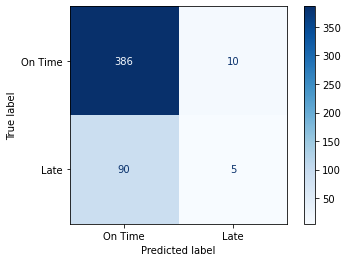

In [37]:
class_names = ['On Time', 'Late']

disp = ConfusionMatrixDisplay.from_estimator(
    trained_model,
    X_test,
    y_test,
    display_labels=class_names,
    cmap=plt.cm.Blues,
    normalize=None)

print("Confusion matrix")
print(disp.confusion_matrix)

plt.show()

The model demonstrates a strong performance in classifying "On Time" returns. However, its effectiveness significantly diminishes when classifying "Late" returns, as evidenced by the very low recall for this category.

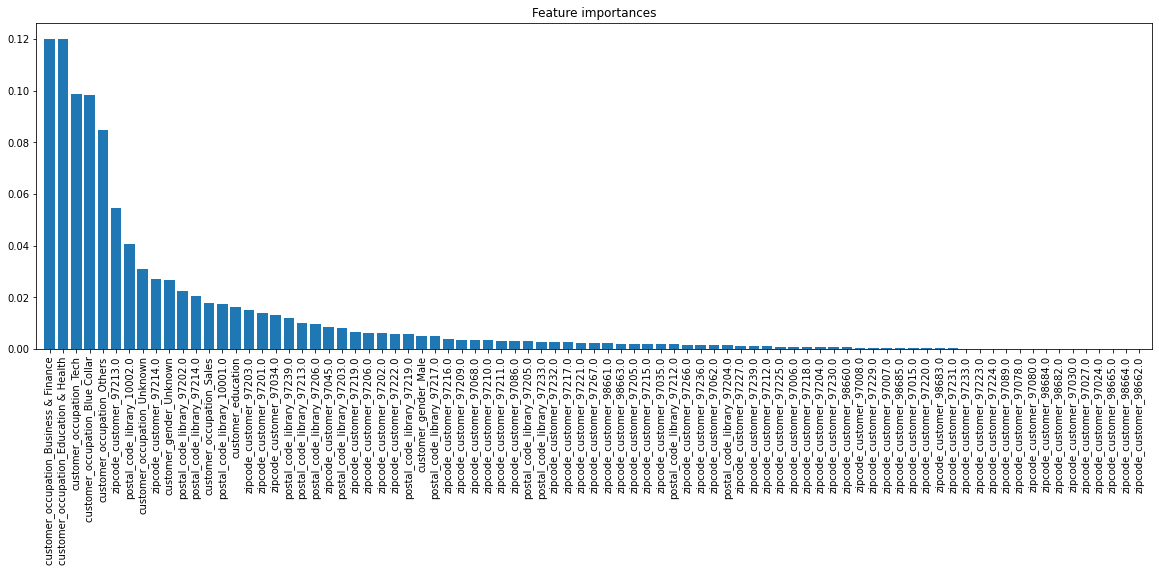

In [ ]:
feature_importances = best_rf_model.feature_importances_
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(20, 6))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

### NOTE - 
Training the model without upsampling the minority class results in low overall performance. However, the feature importance map indicates that individuals residing in zip codes 97217 and 97212 significantly contribute to the model's outcomes. This finding aligns with previous analysis results.

The oversampling technique might have produced synthetic data that does not accurately reflect the true distribution and features of customers with late returns.

The model's performance is suboptimal, revealing only a subtle similarity in our earlier analysis. According to the scikit-learn documentation, feature importance can be somewhat misleading in cases of high cardinality.

Reference - https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance

Hence, Permutation feature importance would be better to look at since measures the contribution of each feature to a fitted model’s statistical performance by randomly shuffling the values of a single feature and observing the resulting degradation of the model’s score.

In [ ]:
from sklearn.inspection import permutation_importance

r = permutation_importance(best_rf_model, X_test, y_test,
                           n_repeats=30,
                           random_state=0)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{final_records_df.columns[i]:<10}:  "
              f"{r.importances_mean[i]:.3f} "
              f" +/- {r.importances_std[i]:.3f}")

customer_occupation_Education & Health:  0.048  +/- 0.008
customer_occupation_Business & Finance:  0.046  +/- 0.006
customer_occupation_Sales:  0.039  +/- 0.007
customer_gender_Unknown:  0.034  +/- 0.008
customer_occupation_Blue Collar:  0.028  +/- 0.008
customer_occupation_Others:  0.013  +/- 0.004
zipcode_customer_97212.0:  0.009  +/- 0.004
zipcode_customer_97201.0:  0.003  +/- 0.002
postal_code_library_97202.0:  0.003  +/- 0.001
zipcode_customer_97217.0:  0.002  +/- 0.001


**Steps to Improve overall performance of classification -**
- Fetch additional data and improve data collection processes as mentioned in the analysis. There are a lot of unknown data in the dataset which cannot be used for analysis.
- Use a simpler model like Logistic Regression (might be unfavourable due to large categorical feature set) but be a good base line model for comparison.
- Research into a better upsampling solution for categorical variables. Research this - https://statistics.berkeley.edu/sites/default/files/tech-reports/666.pdf
- Adjust the decision threshold to balance precision and recall, focusing on reducing false negatives.
- Consider using cost-sensitive learning where false negatives are given a higher penalty.


**Future Steps -**
- Create a Pipeline to set the entire process of preprocessing, encoding and getting predictions from the model.
- Create a Flask/Django API, accepting input from the user/system and output whether the user will default or not. 